# Variational Autoencoder (VAC) training on the given dataset
Luca attempts to train a VAC on the ITALY dataset gotten from the other notebook

In [4]:
!pip install torchvision -q

In [1]:
# mathematics libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# VAE libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

### Defining the VAE

In [74]:
# Define the encoder and decoder networks
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc3(h) # this way we have regression, if not we do classification with: torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z # z are the latent representations of the input x 

# Loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD, MSE, KLD
    

### Loading the dataset

In [75]:
df = pd.read_csv('output/ITALY_dataset.csv') # loading the day-night dataset

# ratio of renewable energy / load for a given timestamp (if < 1 renewable energy is not enough) 
ren_ratio = (df['solar_a'] + df['wind_a'] + df['hydro_a']) / df['load_a']

df['ren_ratio'] = ren_ratio

# this computes the total generation / total load
df['tot_ratio'] = df['generation_a'] / df['load_a']
df


,node_id,time_window,window_start,t,tp,solar,ws10,ws100,solar_a,wind_a,hydro_a,generation_a,load_a,ren_ratio,tot_ratio
0,IT_CALA,day,2022-01-01 06:00:00+00:00,285.435202,1.360361e-05,703479.111111,16.402459,23.951258,1241.0,6117.0,1072.0,14355.0,11960.0,0.704849,1.200251
1,IT_CALA,day,2022-01-02 06:00:00+00:00,285.609332,1.649062e-06,750732.444444,11.872903,17.003888,1262.0,4347.0,1056.0,10396.0,7828.0,0.851431,1.328053
2,IT_CALA,day,2022-01-03 06:00:00+00:00,284.018298,1.307940e-05,681079.111111,16.127072,21.415452,1161.0,6614.0,1155.0,27071.0,15059.0,0.593001,1.797663
3,IT_CALA,day,2022-01-04 06:00:00+00:00,285.407443,1.375492e-07,764110.222222,10.705365,14.512140,1038.0,4764.0,1020.0,25516.0,14880.0,0.458468,1.714785
4,IT_CALA,day,2022-01-05 06:00:00+00:00,287.234285,0.000000e+00,834547.555556,12.264336,16.324974,1175.0,3887.0,891.0,24193.0,15506.0,0.383916,1.560235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13147,IT_SICI,night,2024-12-27 18:00:00+00:00,280.486853,2.111575e-06,0.000000,8.697010,13.051970,0.0,4992.0,139.0,11898.0,21347.0,0.240362,0.557362
13148,IT_SICI,night,2024-12-28 18:00:00+00:00,279.911233,3.748162e-06,0.000000,7.361006,10.078508,0.0,2040.0,155.0,10290.0,20772.0,0.105671,0.495378
13149,IT_SICI,night,2024-12-29 18:00:00+00:00,279.623201,7.854876e-08,0.000000,4.924874,5.261758,0.0,485.0,114.0,9525.0,20353.0,0.029431,0.467990
13150,IT_SICI,night,2024-12-30 18:00:00+00:00,279.441879,1.811242e-07,0.000000,3.925864,3.723855,0.0,241.0,219.0,24022.0,47476.0,0.009689,0.505982


In [176]:
# taking only environmental and energy variables to train
variables_X = ['t','tp','solar','ws10','ws100','solar_a','wind_a','hydro_a']
variables_Y = ['time_window','ren_ratio']

# taking only a specific part ITALY
X = df[df['node_id'] == 'IT_NORD']
Y = X[variables_Y] # label that we try to predict

# converting Y['time_window'] into int values ( day -> 1 , night -> 0)
Y['time_window'] = [1 if x == 'day' else 0 for x in Y['time_window']]

X = X[variables_X]

# scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# convert to pytorch tensor
X_tensor = torch.tensor(X_scaled, dtype = torch.float32)
Y_tensor = torch.tensor(Y.values, dtype = torch.float32) # label that we are trying to predict

# create dataloader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

input_dim = X.shape[1]



/tmp/ipykernel_22689/3867992842.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['time_window'] = [1 if x == 'day' else 0 for x in Y['time_window']]


### Training loop (with grid search)
split train and test set


In [177]:
from torch.utils.data import random_split, DataLoader

# 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Grid search

In [178]:
from sklearn.model_selection import ParameterGrid

# Hyperparameter grid
param_grid = {
    'latent_dim': [2, 3, 4, 5, 6],
    'beta': [0.1, 1, 5],
    'lr': [1e-3, 1e-4, 1e-5]
}

Looking for best parameters in grid search

In [179]:
def evaluate_model(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, _ in dataloader:  # If your dataset has labels
            data = data.to(device)
            recon_batch, mu, logvar, _ = model(data)
            loss, _, _ = loss_function(recon_batch, data, mu, logvar)
            total_loss += loss.item()

    return total_loss / len(dataloader.dataset)


In [250]:
best_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Testing config: {params}")
    
    # Initialize model with current configuration
    model = VAE(input_dim=input_dim, latent_dim=params['latent_dim']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    
    # Train the model (you may want to add validation loss tracking here)
    for epoch in range(30):  # or use early stopping
        model.train()
        total_loss = 0
        for batch in train_loader:
            data = batch[0].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar, z = model(data)
            loss, _, _ = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
    
    # Evaluate the model after training (e.g., validation or test set)
    val_loss = evaluate_model(model, test_loader, loss_function, device)

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
    print('val_loss:', val_loss)

print(f"Best hyperparameters: {best_params}")
latent_dim = best_params['latent_dim']

Testing config: {'beta': 0.1, 'latent_dim': 2, 'lr': 0.001}
val_loss: 5.161628879555809
Testing config: {'beta': 0.1, 'latent_dim': 2, 'lr': 0.0001}
val_loss: 7.488117400497401
Testing config: {'beta': 0.1, 'latent_dim': 2, 'lr': 1e-05}
val_loss: 8.417539140358057
Testing config: {'beta': 0.1, 'latent_dim': 3, 'lr': 0.001}
val_loss: 4.812180990510215
Testing config: {'beta': 0.1, 'latent_dim': 3, 'lr': 0.0001}
val_loss: 7.520164541883187
Testing config: {'beta': 0.1, 'latent_dim': 3, 'lr': 1e-05}
val_loss: 8.53909162725566
Testing config: {'beta': 0.1, 'latent_dim': 4, 'lr': 0.001}
val_loss: 5.092006952724587
Testing config: {'beta': 0.1, 'latent_dim': 4, 'lr': 0.0001}
val_loss: 7.203851791069013
Testing config: {'beta': 0.1, 'latent_dim': 4, 'lr': 1e-05}
val_loss: 8.547116985625179
Testing config: {'beta': 0.1, 'latent_dim': 5, 'lr': 0.001}
val_loss: 4.95169056955394
Testing config: {'beta': 0.1, 'latent_dim': 5, 'lr': 0.0001}
val_loss: 7.25124392151018
Testing config: {'beta': 0.1, '

In [251]:
# retraining on all data with best params and more epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=input_dim, latent_dim=best_params['latent_dim']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

Nepoch = 100

tot_loss = np.zeros(Nepoch)
MSEs = np.zeros(Nepoch)
KLDs = np.zeros(Nepoch)
i = 0

best_loss = float('inf')
best_params = None

for epoch in range(Nepoch):
    
    model.train()
    train_loss = 0
    train_MSE = 0
    train_KLD = 0
    for batch in train_loader:
        data = batch[0].to(device) # takes X to train and ignores Y
        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = model(data)
        loss, MSE, KLD = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        train_MSE += MSE
        train_KLD += KLD
        optimizer.step()
        
    tot_loss[i] = train_loss / len(train_dataset)
    MSEs[i] = train_MSE / len(train_dataset)
    KLDs[i] = train_KLD / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_dataset):.4f}")
    i += 1


Epoch 1, Loss: 8.3189
Epoch 2, Loss: 7.9252
Epoch 3, Loss: 7.5258
Epoch 4, Loss: 7.0609
Epoch 5, Loss: 6.5891
Epoch 6, Loss: 6.1215
Epoch 7, Loss: 5.8906
Epoch 8, Loss: 5.7305
Epoch 9, Loss: 5.6112
Epoch 10, Loss: 5.6045
Epoch 11, Loss: 5.5817
Epoch 12, Loss: 5.4308
Epoch 13, Loss: 5.3394
Epoch 14, Loss: 5.2775
Epoch 15, Loss: 5.2608
Epoch 16, Loss: 5.2441
Epoch 17, Loss: 5.1996
Epoch 18, Loss: 5.1815
Epoch 19, Loss: 5.1346
Epoch 20, Loss: 5.0671
Epoch 21, Loss: 5.0906
Epoch 22, Loss: 5.0635
Epoch 23, Loss: 4.9774
Epoch 24, Loss: 5.0275
Epoch 25, Loss: 5.0098
Epoch 26, Loss: 5.0340
Epoch 27, Loss: 4.9472
Epoch 28, Loss: 5.0057
Epoch 29, Loss: 5.0034
Epoch 30, Loss: 4.9855
Epoch 31, Loss: 4.9427
Epoch 32, Loss: 4.9214
Epoch 33, Loss: 4.9463
Epoch 34, Loss: 4.9717
Epoch 35, Loss: 4.8694
Epoch 36, Loss: 4.9837
Epoch 37, Loss: 4.9160
Epoch 38, Loss: 4.9602
Epoch 39, Loss: 4.9074
Epoch 40, Loss: 4.8899
Epoch 41, Loss: 4.8857
Epoch 42, Loss: 4.8805
Epoch 43, Loss: 4.9144
Epoch 44, Loss: 4.84

### Tracking the losses

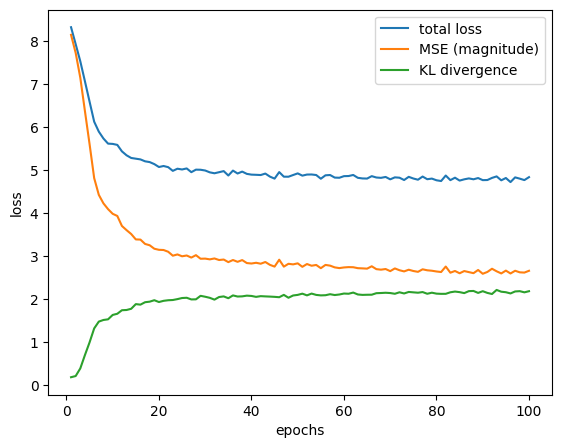

In [252]:
epochs = np.arange(1,Nepoch+1,1)

plt.figure(figsize = (6.5,5))
plt.plot(epochs, tot_loss, label = 'total loss')
plt.plot(epochs, MSEs, label = 'MSE (magnitude)')
plt.plot(epochs, KLDs, label = 'KL divergence')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

as expected KL divergence increases as the encoder regularizes, while the MSE decreases. The total loss decreases and reaches a plateau. Weird thing: i expect a MSE (magnitude) between 0 and 1 if my X are normalized (which are btw...)

### Evaluating performance on test set

In [253]:
all_losses = []
all_labels = []
all_types = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        data = batch[0].to(device)
        recon_batch, mu, logvar, _ = model(data)

        # Reconstruction loss per sample
        losses = F.mse_loss(recon_batch, data, reduction='none').mean(dim=1)
        all_losses.append(losses.cpu())
        # Get associated renewable_coverage (second element in dataset if present)
        labels = batch[1].cpu()  # Assuming you stored renewable_coverage as label
        #print(batch[1][0][0])
        all_types.append(batch[1][0][0])
        all_labels.append(labels)

# Convert to flat arrays
all_losses = torch.cat(all_losses).numpy()
all_labels = torch.cat(all_labels).numpy()


### Visualizing loss vs Renewable coverage

In [254]:
# getting night and day indices
all_indices = np.arange(0, len(all_labels[:,0]),1)
day_indices = np.where(all_labels[:,0] == 1)
night_indices = all_indices[~np.isin(all_indices, day_indices)]

# getting labels and losses relative to day/night
day_labels = all_labels[day_indices,:]
day_losses = all_losses[day_indices]
night_labels = all_labels[night_indices, :]
night_losses = all_losses[night_indices]
#(all_labels[:,1] < 1.0).astype(int)

percentage of under_supplied: 100.0%
percentage of day_under_supplied: 100.0%
percentage of night_under_supplied: 100.0%


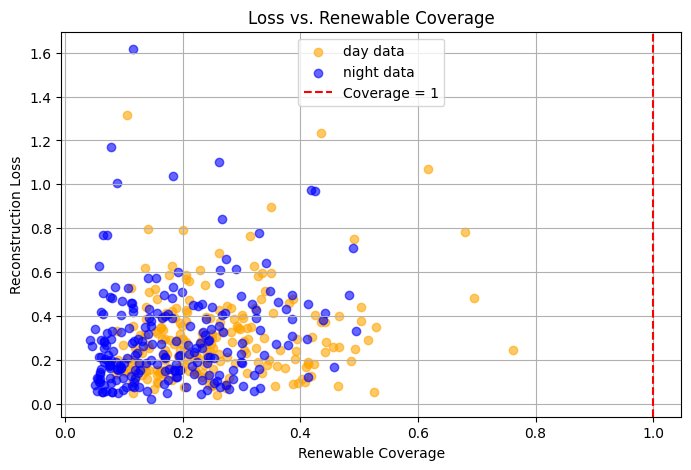

In [255]:
plt.figure(figsize=(8, 5))
plt.scatter(day_labels[0,:,1], day_losses, color = 'orange', label = 'day data', alpha = 0.6)
plt.scatter(night_labels[:,1], night_losses, color = 'blue', label = 'night data', alpha = 0.6)
plt.axvline(1.0, color='red', linestyle='--', label='Coverage = 1')
plt.xlabel("Renewable Coverage")
plt.ylabel("Reconstruction Loss")
plt.title("Loss vs. Renewable Coverage")
plt.legend()
plt.grid(True)

true_labels = (all_labels[:,1] < 1.0).astype(int)  # 1 = under-supplied
true_labels_d = (day_labels[0,:,1] < 1.0).astype(int)  # 1 = under-supplied
true_labels_n = (night_labels[:,1] < 1.0).astype(int)  # 1 = under-supplied
print(f'percentage of under_supplied: {(sum(true_labels) / len(all_labels)*100).round(2)}%')
print(f'percentage of day_under_supplied: {(sum(true_labels_d) / len(day_labels[0])*100).round(2)}%')
print(f'percentage of night_under_supplied: {(sum(true_labels_n) / len(night_labels)*100).round(2)}%')

plt.show()

### Visualizing latent space

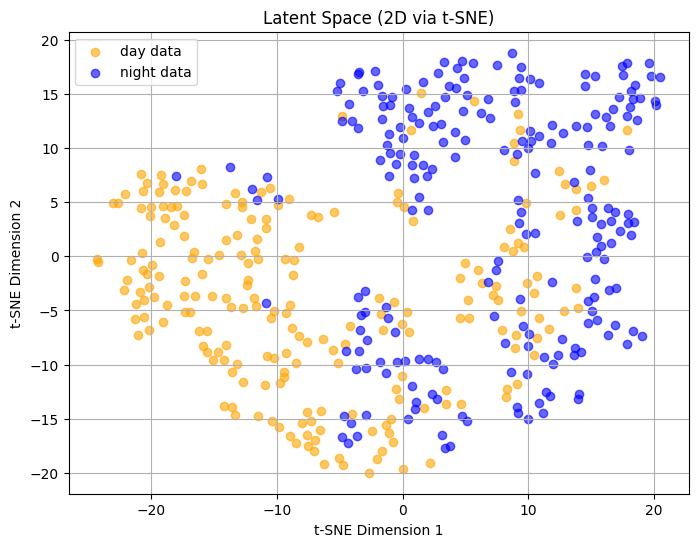

In [261]:
# TSNE allows to represent multiple dimensions vector as 2D vectors (handling well the grid search on 
# hidden space params)
from sklearn.manifold import TSNE

latent_vectors = []
types = []

model.eval()  # Switch to evaluation mode
with torch.no_grad():
    for batch in test_loader:
        data = batch[0].to(device)  # Get the input features (not the labels)
        _, _, _, z = model(data)  # Get the latent representations (z)
        latent_vectors.append(z.cpu().numpy())  # Store the latent vectors on CPU

        # get day / night
        labels = batch[1][:, 0].cpu().numpy()  # Assuming "day/night" is in column 0
        types.extend(labels)    
        

latent_vectors = np.concatenate(latent_vectors, axis=0)  # Combine into one array

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

types = np.array(types)
idx_day = np.where(types == 1)
idx_night = np.where(types == 0)

x_day = latent_tsne[idx_day, 0]
y_day = latent_tsne[idx_day, 1]
x_night = latent_tsne[idx_night, 0]
y_night = latent_tsne[idx_night, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x_day, y_day, alpha=0.6, color = 'orange', label = 'day data')
plt.scatter(x_night, y_night, alpha=0.6, color = 'blue', label = 'night data')
plt.title("Latent Space (2D via t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

## Generating new data with the trained VAE

In [257]:
print(best_params)
model.eval()

# Number of samples to generate
n_samples = 10
latent_dim = latent_dim  # the dimension of your latent space

with torch.no_grad():
    # Sample from standard normal distribution
    z = torch.randn(n_samples, latent_dim).to(device)

    # Decode to generate data
    generated_data = model.decode(z).cpu().numpy()


None
